# **Cifar10 image classification**
******************************************
**점수관련**  
본 프로젝트는 Accuracy 점수와 보고서를 성적에 반영할 예정입니다. 평가 항목은 아래와 같습니다. 

A. 결과 (40%)
- Metric 성능 :(이미지 분류 - Accuracy)

B. 신규성 (30%)
- Network 변경 내용 - **필수**
- 성능 개선 및 overfitting 방지 시도 (ex. train validation split)

C. 이론적 근거 (20%)
- 기존 baseline과의 차별점 
- 성능 개선을 위한 시도와 이유

D. 보고서 완성도 (10%)

******************************************
**보고서**
1. 연구 목적
2. 모델 구조
3. 실험 내용
4. 실험 결과
5. 고찰 및 결론
6. Colab 파일 (동작 가능여부)

제출하실 파일은 **주피터 노트북 파일**('.ipynb',파일>다운로드)과 **결과 보고서**(pdf)입니다.
******************************************
**코드 검증**  
- 코드 성능 평가(metric)는 torchvision.datasets에 있는 cifar10의 testset을 사용해 Accuracy로 평가합니다.
- pretrain 모델 사용 불가능합니다.

또한 Random 라이브러리 사용시에 seed 고정하는 등 재현을 고려하시고 코딩부탁드립니다. 
******************************************
**GPU 사용 법**  
런타임 > 런타임 유형 변경 > 하드웨어 가속기에서 GPU를 선택하면 GPU를 사용 할 수 있습니다.  
******************************************
**Colab 사용시 유의사항**  
12시간 단위로 가상머신을 사용할 수 있고 12시간이 지나면 모든 파일과 작업로그들이 초기화 됩니다. 또한, 12시간 넘게 GPU를 사용하기는 어려우니 일찍 시작하셔서 틈틈히 실험해보시는 것을 추천드립니다.


******************************************
**Q?**

In [1]:
# Training
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm as tqdm
import time
import math
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

torch.manual_seed(0) 
torch.cuda.manual_seed_all(0) 


In [2]:
!nvidia-smi

Mon Nov  1 00:43:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 67%   76C    P2   201W / 260W |   4768MiB / 11016MiB |     84%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   

In [3]:
# 하이퍼 파라미터
EPOCH = 300
batch_size = 64
learning_rate = 0.1
momentum = 0.9
weight_decay = 1e-4

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

# 분류 Class list
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# 이미지 전처리
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

# Dataset. 변경 불가
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


cuda:0 is available
Files already downloaded and verified
Files already downloaded and verified


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# code from https://github.com/KellerJordan/ResNet-PyTorch-CIFAR10/blob/master/model.py
class IdentityPadding(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(IdentityPadding, self).__init__()

        if stride == 2:
            self.pooling = nn.AvgPool2d(kernel_size=2, stride=2, ceil_mode=True)
        else:
            self.pooling = None
            
        self.add_channels = out_channels - in_channels
    
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.add_channels))
        if self.pooling is not None:
            out = self.pooling(out)
        return out


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                                stride=stride, padding=1, bias=False)      
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                                stride=1, padding=1, bias=False)    
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.down_sample = IdentityPadding(in_channels, out_channels, stride)
            
        self.stride = stride

    def forward(self, x):
        shortcut = self.down_sample(x)
        out = self.bn1(x)
        out = self.conv1(out)        
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
       
        out += shortcut
        return out


class PyramidNet(nn.Module):
    def __init__(self, num_layers, alpha, block, num_classes=10):
        super(PyramidNet, self).__init__()   	
        self.in_channels = 16
        
        # num_layers = (110 - 2)/6 = 18
        self.num_layers = num_layers
        self.addrate = alpha / (3*self.num_layers*1.0)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # feature map size = 32x32
        self.layer1 = self.get_layers(block, stride=1)
        # feature map size = 16x16
        self.layer2 = self.get_layers(block, stride=2)
        # feature map size = 8x8
        self.layer3 = self.get_layers(block, stride=2)

        self.out_channels = int(round(self.out_channels))
        self.bn_out= nn.BatchNorm2d(self.out_channels)
        self.relu_out = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc_out = nn.Linear(self.out_channels, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', 
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def get_layers(self, block, stride):
        layers_list = []
        for _ in range(self.num_layers - 1):
            self.out_channels = self.in_channels + self.addrate
            layers_list.append(block(int(round(self.in_channels)), 
                                     int(round(self.out_channels)), 
                                     stride))
            self.in_channels = self.out_channels
            stride=1

        return nn.Sequential(*layers_list)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.bn_out(x)
        x = self.relu_out(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)
        return x



In [5]:
# def pyramidnet():
# 	block = ResidualBlock
# 	model = PyramidNet(num_layers=18, alpha=48, block=block)
# 	return model

def pyramidnet():
    block = ResidualBlock
    model = PyramidNet(num_layers=45, alpha=200, block=block)
    return model

model = pyramidnet().to(device)

In [6]:
# criterion. 변경 '가능'
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225], gamma=0.1, verbose=True)

loss_ = []
n = len(trainloader)  # number of batches

# Training
for epoch in range(EPOCH): 

  running_loss = 0.0
  start = time.time()
  pbar = tqdm(trainloader)
  for batch, (X, y) in enumerate(pbar):
    
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad() # 배치마다 optimizer 초기화

    pred = model(X) 
    loss = criterion(pred, y) # 크로스 엔트로피 손실함수 계산 
      

    loss.backward() # backpropagation
    optimizer.step() # 가중치 최적화

    running_loss += loss.item()
  
  if (epoch + 1) % 10 == 0:
    dir = './model_' + str(epoch) + '.pt'
    torch.save(model.state_dict() , dir) # 모델 저장, path 수정
  loss_.append(running_loss / n)
  print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))
  print("epoch time :", time.time()-start)
  scheduler.step()




  0%|          | 0/782 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[1] loss: 1.530
epoch time : 301.33236169815063
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[2] loss: 0.945
epoch time : 301.43718934059143
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[3] loss: 0.715
epoch time : 300.64077949523926
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[4] loss: 0.603
epoch time : 301.49736499786377
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[5] loss: 0.532
epoch time : 301.2990128993988
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[6] loss: 0.480
epoch time : 301.07102942466736
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[7] loss: 0.442
epoch time : 301.4610433578491
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[8] loss: 0.412
epoch time : 301.5420882701874
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[9] loss: 0.385
epoch time : 301.628689289093
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[10] loss: 0.363
epoch time : 301.905916929245
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[11] loss: 0.345
epoch time : 300.8451669216156
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[12] loss: 0.326
epoch time : 300.6563913822174
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[13] loss: 0.311
epoch time : 300.7899134159088
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[14] loss: 0.290
epoch time : 300.63817071914673
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[15] loss: 0.277
epoch time : 300.69188714027405
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[16] loss: 0.265
epoch time : 300.4934434890747
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[17] loss: 0.256
epoch time : 300.59044575691223
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[18] loss: 0.250
epoch time : 300.729364156723
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[19] loss: 0.241
epoch time : 300.7612192630768
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[20] loss: 0.226
epoch time : 301.0007586479187
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[21] loss: 0.224
epoch time : 300.9551889896393
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[22] loss: 0.211
epoch time : 300.8234314918518
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[23] loss: 0.212
epoch time : 300.6728582382202
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[24] loss: 0.203
epoch time : 300.57743763923645
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[25] loss: 0.201
epoch time : 300.9206700325012
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[26] loss: 0.196
epoch time : 301.0310206413269
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[27] loss: 0.192
epoch time : 300.5892617702484
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[28] loss: 0.190
epoch time : 300.8257246017456
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[29] loss: 0.190
epoch time : 300.8337559700012
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[30] loss: 0.180
epoch time : 301.40406584739685
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[31] loss: 0.184
epoch time : 300.6922175884247
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[32] loss: 0.171
epoch time : 301.31784772872925
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[33] loss: 0.173
epoch time : 301.26407170295715
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[34] loss: 0.171
epoch time : 300.89625239372253
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[35] loss: 0.165
epoch time : 300.81299209594727
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[36] loss: 0.165
epoch time : 300.7605023384094
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[37] loss: 0.162
epoch time : 300.62414383888245
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[38] loss: 0.163
epoch time : 301.0288109779358
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[39] loss: 0.156
epoch time : 300.49478363990784
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[40] loss: 0.157
epoch time : 301.50473523139954
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[41] loss: 0.154
epoch time : 300.5536572933197
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[42] loss: 0.151
epoch time : 300.9791941642761
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[43] loss: 0.152
epoch time : 300.66725039482117
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[44] loss: 0.152
epoch time : 300.7966556549072
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[45] loss: 0.148
epoch time : 300.62959003448486
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[46] loss: 0.148
epoch time : 300.6336841583252
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[47] loss: 0.145
epoch time : 300.7979521751404
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[48] loss: 0.144
epoch time : 300.5683333873749
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[49] loss: 0.140
epoch time : 300.70367980003357
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[50] loss: 0.145
epoch time : 301.344854593277
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[51] loss: 0.137
epoch time : 300.6147849559784
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[52] loss: 0.135
epoch time : 300.7956202030182
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[53] loss: 0.142
epoch time : 300.7983946800232
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[54] loss: 0.135
epoch time : 300.72247862815857
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[55] loss: 0.135
epoch time : 300.4553439617157
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[56] loss: 0.132
epoch time : 300.8684911727905
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[57] loss: 0.136
epoch time : 300.87214946746826
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[58] loss: 0.130
epoch time : 300.6331596374512
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[59] loss: 0.137
epoch time : 300.6769070625305
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[60] loss: 0.135
epoch time : 301.4749684333801
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[61] loss: 0.134
epoch time : 301.05044293403625
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[62] loss: 0.130
epoch time : 300.8488531112671
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[63] loss: 0.130
epoch time : 300.6272222995758
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[64] loss: 0.133
epoch time : 301.187362909317
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[65] loss: 0.133
epoch time : 300.60972261428833
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[66] loss: 0.124
epoch time : 300.7817988395691
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[67] loss: 0.126
epoch time : 300.76464653015137
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[68] loss: 0.124
epoch time : 300.8413689136505
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[69] loss: 0.126
epoch time : 300.6322422027588
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[70] loss: 0.124
epoch time : 301.2494857311249
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[71] loss: 0.124
epoch time : 300.48564076423645
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[72] loss: 0.125
epoch time : 300.7851686477661
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[73] loss: 0.127
epoch time : 300.6713743209839
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[74] loss: 0.123
epoch time : 300.543527841568
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[75] loss: 0.119
epoch time : 300.91276955604553
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[76] loss: 0.125
epoch time : 300.96896266937256
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[77] loss: 0.120
epoch time : 300.78377175331116
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[78] loss: 0.120
epoch time : 300.9045886993408
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[79] loss: 0.121
epoch time : 300.66390776634216
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[80] loss: 0.124
epoch time : 301.34314012527466
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[81] loss: 0.121
epoch time : 300.85780239105225
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[82] loss: 0.122
epoch time : 300.67084193229675
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[83] loss: 0.114
epoch time : 300.6729004383087
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[84] loss: 0.119
epoch time : 300.7725009918213
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[85] loss: 0.122
epoch time : 300.7011272907257
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[86] loss: 0.117
epoch time : 300.93664932250977
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[87] loss: 0.119
epoch time : 301.0594117641449
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[88] loss: 0.123
epoch time : 300.8795545101166
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[89] loss: 0.120
epoch time : 300.89887261390686
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[90] loss: 0.121
epoch time : 301.48800134658813
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[91] loss: 0.119
epoch time : 300.8256781101227
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[92] loss: 0.118
epoch time : 300.64571952819824
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[93] loss: 0.118
epoch time : 300.8853769302368
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[94] loss: 0.113
epoch time : 300.69476771354675
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[95] loss: 0.109
epoch time : 300.7500376701355
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[96] loss: 0.122
epoch time : 300.79283118247986
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[97] loss: 0.115
epoch time : 300.6926922798157
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[98] loss: 0.114
epoch time : 300.627072095871
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[99] loss: 0.116
epoch time : 301.0038831233978
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[100] loss: 0.116
epoch time : 301.28729367256165
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[101] loss: 0.115
epoch time : 300.6369400024414
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[102] loss: 0.114
epoch time : 300.564083814621
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[103] loss: 0.112
epoch time : 300.8085603713989
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[104] loss: 0.121
epoch time : 300.4811096191406
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[105] loss: 0.112
epoch time : 300.61115622520447
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[106] loss: 0.114
epoch time : 300.6585190296173
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[107] loss: 0.115
epoch time : 300.8900992870331
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[108] loss: 0.113
epoch time : 300.5162761211395
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[109] loss: 0.117
epoch time : 300.6048300266266
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[110] loss: 0.110
epoch time : 301.0335478782654
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[111] loss: 0.109
epoch time : 300.7521221637726
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[112] loss: 0.112
epoch time : 300.3717415332794
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[113] loss: 0.116
epoch time : 300.7021369934082
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[114] loss: 0.111
epoch time : 300.82948088645935
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[115] loss: 0.115
epoch time : 300.768994808197
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[116] loss: 0.114
epoch time : 300.61993646621704
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[117] loss: 0.113
epoch time : 300.84640741348267
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[118] loss: 0.110
epoch time : 300.5757677555084
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[119] loss: 0.109
epoch time : 300.6018543243408
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[120] loss: 0.111
epoch time : 301.50119495391846
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[121] loss: 0.110
epoch time : 300.7411861419678
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[122] loss: 0.106
epoch time : 300.87779474258423
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[123] loss: 0.117
epoch time : 300.66156220436096
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[124] loss: 0.117
epoch time : 300.82369327545166
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[125] loss: 0.107
epoch time : 300.685822725296
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[126] loss: 0.108
epoch time : 300.61744689941406
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[127] loss: 0.110
epoch time : 300.60399198532104
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[128] loss: 0.113
epoch time : 300.78788781166077
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[129] loss: 0.111
epoch time : 300.8877844810486
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[130] loss: 0.109
epoch time : 300.9868748188019
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[131] loss: 0.107
epoch time : 300.7452507019043
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[132] loss: 0.110
epoch time : 300.9910705089569
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[133] loss: 0.112
epoch time : 300.6131694316864
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[134] loss: 0.104
epoch time : 300.6745903491974
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[135] loss: 0.113
epoch time : 300.6676187515259
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[136] loss: 0.104
epoch time : 300.53903222084045
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[137] loss: 0.112
epoch time : 300.755982875824
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[138] loss: 0.109
epoch time : 300.6657898426056
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[139] loss: 0.105
epoch time : 300.8848316669464
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[140] loss: 0.106
epoch time : 301.44751167297363
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[141] loss: 0.110
epoch time : 300.8093168735504
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[142] loss: 0.111
epoch time : 300.8113143444061
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[143] loss: 0.109
epoch time : 300.48632431030273
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[144] loss: 0.111
epoch time : 300.75678539276123
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[145] loss: 0.113
epoch time : 300.45719385147095
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[146] loss: 0.107
epoch time : 300.635995388031
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[147] loss: 0.107
epoch time : 300.65066480636597
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[148] loss: 0.111
epoch time : 300.2912485599518
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[149] loss: 0.109
epoch time : 300.7472298145294
Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/782 [00:00<?, ?it/s]

[150] loss: 0.108
epoch time : 301.1279239654541
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[151] loss: 0.035
epoch time : 301.03214955329895
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[152] loss: 0.014
epoch time : 300.73609232902527
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[153] loss: 0.010
epoch time : 300.6305122375488
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[154] loss: 0.007
epoch time : 300.5300567150116
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[155] loss: 0.006
epoch time : 300.7827322483063
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[156] loss: 0.005
epoch time : 300.81222558021545
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[157] loss: 0.004
epoch time : 300.77550768852234
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[158] loss: 0.004
epoch time : 300.6361174583435
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[159] loss: 0.003
epoch time : 300.50224137306213
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[160] loss: 0.003
epoch time : 301.32144236564636
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[161] loss: 0.003
epoch time : 300.9440529346466
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[162] loss: 0.002
epoch time : 300.9789209365845
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[163] loss: 0.002
epoch time : 300.66619420051575
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[164] loss: 0.002
epoch time : 300.64962935447693
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[165] loss: 0.002
epoch time : 300.513329744339
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[166] loss: 0.002
epoch time : 300.81083273887634
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[167] loss: 0.002
epoch time : 300.6281805038452
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[168] loss: 0.002
epoch time : 300.8765518665314
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[169] loss: 0.002
epoch time : 300.6595313549042
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[170] loss: 0.001
epoch time : 301.40795040130615
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[171] loss: 0.001
epoch time : 300.7443172931671
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[172] loss: 0.002
epoch time : 300.7181224822998
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[173] loss: 0.001
epoch time : 300.93815207481384
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[174] loss: 0.001
epoch time : 300.93991208076477
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[175] loss: 0.001
epoch time : 300.7484767436981
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[176] loss: 0.001
epoch time : 300.8427224159241
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[177] loss: 0.001
epoch time : 300.95879578590393
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[178] loss: 0.001
epoch time : 301.0149006843567
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[179] loss: 0.001
epoch time : 301.0247929096222
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[180] loss: 0.001
epoch time : 301.4260399341583
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[181] loss: 0.001
epoch time : 300.7393572330475
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[182] loss: 0.001
epoch time : 300.9548177719116
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[183] loss: 0.001
epoch time : 300.6877794265747
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[184] loss: 0.001
epoch time : 300.92984318733215
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[185] loss: 0.001
epoch time : 300.50014090538025
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[186] loss: 0.001
epoch time : 300.56483268737793
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[187] loss: 0.001
epoch time : 300.6260027885437
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[188] loss: 0.001
epoch time : 300.7245919704437
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[189] loss: 0.001
epoch time : 300.6429877281189
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[190] loss: 0.001
epoch time : 301.2509615421295
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[191] loss: 0.001
epoch time : 300.5849757194519
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[192] loss: 0.001
epoch time : 300.3101258277893
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[193] loss: 0.001
epoch time : 300.5043897628784
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[194] loss: 0.001
epoch time : 300.35296392440796
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[195] loss: 0.001
epoch time : 300.4975278377533
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[196] loss: 0.001
epoch time : 300.2203869819641
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[197] loss: 0.001
epoch time : 300.28380584716797
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[198] loss: 0.001
epoch time : 300.68830919265747
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[199] loss: 0.001
epoch time : 300.5879428386688
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[200] loss: 0.001
epoch time : 301.13459491729736
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[201] loss: 0.001
epoch time : 300.67787647247314
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[202] loss: 0.001
epoch time : 300.5816786289215
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[203] loss: 0.001
epoch time : 300.65052223205566
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[204] loss: 0.001
epoch time : 300.77988839149475
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[205] loss: 0.001
epoch time : 300.5534517765045
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[206] loss: 0.001
epoch time : 300.34234285354614
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[207] loss: 0.001
epoch time : 300.53416204452515
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[208] loss: 0.001
epoch time : 300.7189395427704
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[209] loss: 0.001
epoch time : 300.6375563144684
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[210] loss: 0.001
epoch time : 301.33781147003174
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[211] loss: 0.001
epoch time : 300.7945833206177
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[212] loss: 0.001
epoch time : 301.01411509513855
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[213] loss: 0.001
epoch time : 301.184588432312
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[214] loss: 0.001
epoch time : 300.86694955825806
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[215] loss: 0.001
epoch time : 300.87568640708923
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[216] loss: 0.001
epoch time : 300.6555600166321
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[217] loss: 0.001
epoch time : 300.70658683776855
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[218] loss: 0.001
epoch time : 300.7945177555084
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[219] loss: 0.001
epoch time : 300.60858249664307
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[220] loss: 0.001
epoch time : 301.32028579711914
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[221] loss: 0.001
epoch time : 300.72056579589844
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[222] loss: 0.001
epoch time : 300.57890939712524
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[223] loss: 0.001
epoch time : 300.8338739871979
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[224] loss: 0.002
epoch time : 300.54884243011475
Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/782 [00:00<?, ?it/s]

[225] loss: 0.003
epoch time : 300.5742952823639
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[226] loss: 0.001
epoch time : 300.6648232936859
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[227] loss: 0.001
epoch time : 300.8536307811737
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[228] loss: 0.001
epoch time : 300.9520492553711
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[229] loss: 0.001
epoch time : 300.697895526886
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[230] loss: 0.001
epoch time : 301.3475875854492
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[231] loss: 0.001
epoch time : 300.2628712654114
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[232] loss: 0.001
epoch time : 300.67145586013794
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[233] loss: 0.001
epoch time : 300.5877459049225
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[234] loss: 0.001
epoch time : 300.91564893722534
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[235] loss: 0.001
epoch time : 300.63564252853394
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[236] loss: 0.001
epoch time : 300.50345492362976
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[237] loss: 0.001
epoch time : 300.8198072910309
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[238] loss: 0.001
epoch time : 300.7525508403778
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[239] loss: 0.001
epoch time : 300.6383934020996
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[240] loss: 0.001
epoch time : 301.2627983093262
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[241] loss: 0.001
epoch time : 300.1923792362213
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[242] loss: 0.001
epoch time : 300.31566882133484
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[243] loss: 0.001
epoch time : 300.43755078315735
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[244] loss: 0.001
epoch time : 300.60851216316223
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[245] loss: 0.001
epoch time : 300.6688895225525
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[246] loss: 0.001
epoch time : 300.2695429325104
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[247] loss: 0.001
epoch time : 300.7227318286896
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[248] loss: 0.001
epoch time : 300.4776346683502
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[249] loss: 0.001
epoch time : 300.68543767929077
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[250] loss: 0.001
epoch time : 301.2371413707733
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[251] loss: 0.001
epoch time : 300.24564933776855
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[252] loss: 0.001
epoch time : 300.338196516037
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[253] loss: 0.001
epoch time : 300.3839318752289
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[254] loss: 0.001
epoch time : 300.506231546402
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[255] loss: 0.001
epoch time : 300.4700872898102
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[256] loss: 0.001
epoch time : 300.5664620399475
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[257] loss: 0.000
epoch time : 300.62617778778076
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[258] loss: 0.000
epoch time : 300.50283336639404
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[259] loss: 0.000
epoch time : 300.7137620449066
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[260] loss: 0.000
epoch time : 301.0958843231201
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[261] loss: 0.000
epoch time : 300.28336000442505
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[262] loss: 0.000
epoch time : 300.1272828578949
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[263] loss: 0.000
epoch time : 300.1609742641449
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[264] loss: 0.000
epoch time : 300.42635703086853
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[265] loss: 0.000
epoch time : 300.0751302242279
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[266] loss: 0.000
epoch time : 300.04930782318115
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[267] loss: 0.001
epoch time : 300.03471088409424
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[268] loss: 0.001
epoch time : 299.6757071018219
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[269] loss: 0.000
epoch time : 299.87338423728943
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[270] loss: 0.001
epoch time : 300.58732891082764
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[271] loss: 0.000
epoch time : 299.8770625591278
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[272] loss: 0.000
epoch time : 300.0030379295349
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[273] loss: 0.000
epoch time : 299.8139114379883
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[274] loss: 0.000
epoch time : 299.73975706100464
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[275] loss: 0.000
epoch time : 300.07326221466064
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[276] loss: 0.000
epoch time : 300.0212986469269
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[277] loss: 0.001
epoch time : 299.99356174468994
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[278] loss: 0.000
epoch time : 299.81766295433044
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[279] loss: 0.000
epoch time : 299.66912293434143
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[280] loss: 0.000
epoch time : 300.4749209880829
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[281] loss: 0.000
epoch time : 300.2329752445221
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[282] loss: 0.000
epoch time : 300.0651128292084
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[283] loss: 0.000
epoch time : 299.7390167713165
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[284] loss: 0.001
epoch time : 299.87009024620056
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[285] loss: 0.000
epoch time : 300.17280888557434
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[286] loss: 0.000
epoch time : 299.77768087387085
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[287] loss: 0.000
epoch time : 299.95419120788574
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[288] loss: 0.000
epoch time : 300.1589388847351
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[289] loss: 0.000
epoch time : 300.32264828681946
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[290] loss: 0.000
epoch time : 300.7286353111267
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[291] loss: 0.000
epoch time : 300.0714828968048
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[292] loss: 0.000
epoch time : 300.16712641716003
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[293] loss: 0.000
epoch time : 300.4252805709839
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[294] loss: 0.000
epoch time : 300.53602957725525
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[295] loss: 0.001
epoch time : 300.3681492805481
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[296] loss: 0.000
epoch time : 300.2067172527313
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[297] loss: 0.000
epoch time : 300.3210437297821
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[298] loss: 0.000
epoch time : 300.3373124599457
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/782 [00:00<?, ?it/s]

[299] loss: 0.000
epoch time : 300.47710037231445
Adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 782/782 [05:00<00:00,  2.60it/s]


[300] loss: 0.000
epoch time : 300.966162443161
Adjusting learning rate of group 0 to 1.0000e-03.


# Evaluation

In [9]:
# Evaluation

# 수정
# net = ResNet152().to(device)
net = model
# net.load_state_dict(torch.load('/content/gdrive/MyDrive/Baseline//model_ckpt.pt')) # 저장된 모델 불러오기


# 이하 전체 수정 불가
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

total :  10000
Accuracy of the network on the 10000 test images: 95 %
Accuracy for class plane is: 96.7 %
Accuracy for class car   is: 97.8 %
Accuracy for class bird  is: 94.1 %
Accuracy for class cat   is: 89.1 %
Accuracy for class deer  is: 96.6 %
Accuracy for class dog   is: 93.0 %
Accuracy for class frog  is: 97.4 %
Accuracy for class horse is: 97.4 %
Accuracy for class ship  is: 97.4 %
Accuracy for class truck is: 96.8 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


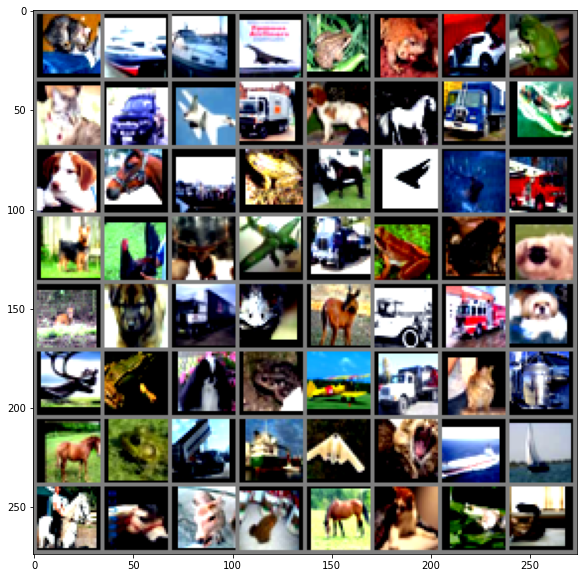

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog
Predicted:  horse   dog  ship plane  ship  deer horse plane


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

net = model
# net = Net()
# net.to(device)
# net.load_state_dict(torch.load('/content/gdrive/MyDrive/Baseline//model_ckpt.pt'))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))